# Fitting V4 voxels from Alexnet conv3 features - take #2
Here we're trying again to find a mapping from the alexnet conv3 feature space to the V4 voxel space. But this time the features come from 'retinawarp'ed' input images

In [2]:
#basic imports
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import pymongo as pm
import numpy as np
import h5py
import scipy as sp
import scipy.stats as stats
import os

from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import RidgeCV, Ridge

In [3]:
# load and organize brain data

#read in the mat files
with h5py.File('data/EstimatedResponses.mat','r') as fmri_dataset:
    train_S1 = fmri_dataset['dataTrnS1'][:]
    test_S1 = fmri_dataset['dataValS1'][:]
    roi_S1 = fmri_dataset['roiS1'][:]
    
    train_S2 = fmri_dataset['dataTrnS2'][:]
    test_S2 = fmri_dataset['dataValS2'][:]
    roi_S2 = fmri_dataset['roiS2'][:]
    
    unique_ROIs = np.unique((fmri_dataset['roiS1'])) 
    
#organize subject 1
S1_train_data_by_ROI = {c: train_S1[:,roi_S1[0,:] == c] 
                       for c in unique_ROIs}
S1_test_data_by_ROI = {c: test_S1[:,roi_S1[0,:] == c] 
                       for c in unique_ROIs}
#organize subject 2
S2_train_data_by_ROI = {c: train_S2[:,roi_S2[0,:] == c] 
                       for c in unique_ROIs}
S2_test_data_by_ROI = {c: test_S2[:,roi_S2[0,:] == c] 
                       for c in unique_ROIs}

#Select only V4 voxels & get rid of any voxels that have NaNs for any training images
#Subject 1
S1_V4 = S1_train_data_by_ROI[6.0].T
x=S1_V4[~np.isnan(S1_V4).any(axis=1)]
S1_V4_train = x.T
S1_V4_val = S1_test_data_by_ROI[6.0].T
x=S1_V4_val[~np.isnan(S1_V4).any(axis=1)]
S1_V4_test = x.T
#Subject 2
S2_V4 = S2_train_data_by_ROI[6.0].T
x=S2_V4[~np.isnan(S2_V4).any(axis=1)]
S2_V4_train = x.T
S2_V4_val = S2_test_data_by_ROI[6.0].T
x=S2_V4_val[~np.isnan(S2_V4).any(axis=1)]
S2_V4_test = x.T
sum(sum(np.isnan(S2_V4_test))) #make sure we don't have any NaNs left in the test data

0

In [4]:
# read in the alexnet features
h5f = h5py.File('alexnet/alexnet_conv3_features_retinawarp.h5','r')
train_features = h5f['train'][:] #features for the training images
val_features = h5f['val'][:] #features for the validation images
h5f.close()

In [5]:
# define some useful functions - note that everything in this cell is adapted from Yamins lab functions
# (https://github.com/neuroailab/psych253)
def rsquared(v1, v2):
    w, b, r, p, ser = stats.linregress(v1, v2)
    return r**2

def evaluate_regression_results(predicted, actual):
    """computing various useful metrics for regression results
    """
    result = {}
    if actual.ndim > 1: #this is triggered if the prediction is of multiple outputs at once
        result['pearson_array'] = np.array([stats.pearsonr(p, a)[0] for p, a in zip(predicted.T, actual.T)])
        result['spearman_array'] = np.array([stats.spearmanr(p, a)[0] for p, a in zip(predicted.T, actual.T)])
        result['rsquared_array'] = np.array([rsquared(p, a) for p, a in zip(predicted.T, actual.T)])
        result['pearson'] = np.median(result['pearson_array'])
        result['spearman'] = np.median(result['spearman_array'])
        result['rsquared'] = np.median(result['rsquared_array'])
    else:
        result['pearson'] = stats.pearsonr(predicted, actual)[0]
        result['spearman'] = stats.spearmanr(predicted, actual)[0]
        result['rsquared'] = rsquared(predicted, actual)
    return result

def aggregate_regression_results(results_by_split):
    """convenience function aggregating results of regression tests over data splits
    """
    results = {}
    results['by_split'] = results_by_split
    ns = len(results_by_split)
    for k in results_by_split[0]:
        arr = np.array([results_by_split[i][k] for i in range(ns)])
        if arr.ndim == 1:
            results['mean_' + k] = arr.mean()
            results['std_' + k] = arr.std()
        else:
            results['mean_' + k] = arr.mean(axis=0)
            results['std_' + k] = arr.std(axis=0)
    return results

def train_and_test_scikit_regressor(features, 
                                    labels,
                                    splits,
                                    model_class,
                                    model_args=None,
                                    gridcv_params=None,
                                    gridcv_args=None,
                                    fit_args=None,
                                    return_models=False
                                    ):

    if model_args is None:
        model_args = {}
    if fit_args is None:
        fit_args = {}
    
    training_sidedata = []
   
    models = []
    train_results = []
    test_results = []
    
    for split in splits:

        #here we instantiate the general regressor whatever it is
        model = model_class(**model_args)
        if gridcv_params is not None:
            if gridcv_args is None:
                gridcv_args = {}
            model = GridSearchCV(model, gridcv_params, **gridcv_args)
            
        #get the train/test split data
        train_inds = split['train']
        test_inds = split['test']
        train_features = features[train_inds]
        train_labels = labels[train_inds]
        test_features = features[test_inds]
        test_labels = labels[test_inds]

        #train the model ...
        model.fit(train_features, train_labels, **fit_args)
        
        #... and get training predictions and results
        train_predictions = model.predict(train_features)
        train_result = evaluate_regression_results(train_predictions, train_labels)
        train_results.append(train_result)
             
        #... and get testing predictions and results
        test_predictions = model.predict(test_features)
        test_result = evaluate_regression_results(test_predictions, test_labels)
        test_results.append(test_result)
        
        if return_models:
            models.append(model)
        
    #aggregate results over splits
    train_results = aggregate_regression_results(train_results)
    test_results = aggregate_regression_results(test_results)
    results = {'train': train_results,
               'test': test_results,
               'training_sidedata': training_sidedata}
    if return_models:
            results['models'] = models
            
    return results

In [6]:
#flatten the conv features
shp = train_features.shape
train_feats = train_features.reshape((shp[0], np.prod(shp[1:])))
print(train_feats.shape)

shp = val_features.shape
val_feats = val_features.reshape((shp[0], np.prod(shp[1:])))
print(val_feats.shape)

(1750, 75264)
(120, 75264)


In [7]:
# create our own train test splits 
total_imgs = 1750
num_splits = 5
num_per_class_test=250
num_per_class_train=1500

#seed the random number generator
rng = np.random.RandomState(seed=0)

In [8]:
#construct the splits 
splits = []
for _split_ind in range(num_splits):
    
    #first construct the testing data
    actual_test_inds = []
    
    perm = rng.permutation(total_imgs)
    actual_test_inds = perm[ :num_per_class_test]
    
    actual_test_inds = np.sort(actual_test_inds)
    
    # then training
    remaining_available_train_inds = np.unique(list(set(
                       perm).difference(actual_test_inds)))
    actual_train_inds = np.sort(remaining_available_train_inds)

    split = {'train': actual_train_inds, 'test': actual_test_inds}
    splits.append(split)

In [9]:
## let's subsample the features - should speed things up/maybe help with overfitting?
n = train_feats.shape[1]  
perm = rng.permutation(n)
#let's just keep 5000
keep_inds = perm[: 5000]
train_feats_sub = train_feats[:, keep_inds]
val_feats_sub = val_feats[:, keep_inds]

## Regressions - Subject 1

In [10]:
# let's start with the basic overall PLS regression
resPLS = train_and_test_scikit_regressor(features=train_feats, 
                                labels=S1_V4_train,
                                splits=splits,
                                model_class=PLSRegression,
                                model_args={'n_components': 25,
                                            'scale': False})

In [11]:
print(resPLS['train']['mean_rsquared']) 
print(resPLS['test']['mean_rsquared']) 

0.02439136585419857
0.0019705014201520325


This seems to have made it worse?!

In [12]:
#and now with the subsampled features
resPLS_sub = train_and_test_scikit_regressor(features=train_feats_sub, 
                                labels=S1_V4_train,
                                splits=splits,
                                model_class=PLSRegression,
                                model_args={'n_components': 25,
                                            'scale': False},
                                return_models=True)

In [13]:
print(resPLS_sub['train']['mean_rsquared']) 
print(resPLS_sub['test']['mean_rsquared']) 

0.02382317655510558
0.0019588803802350944


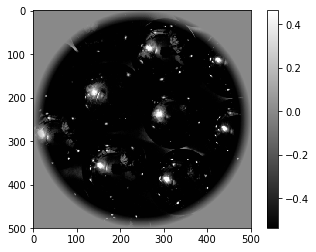

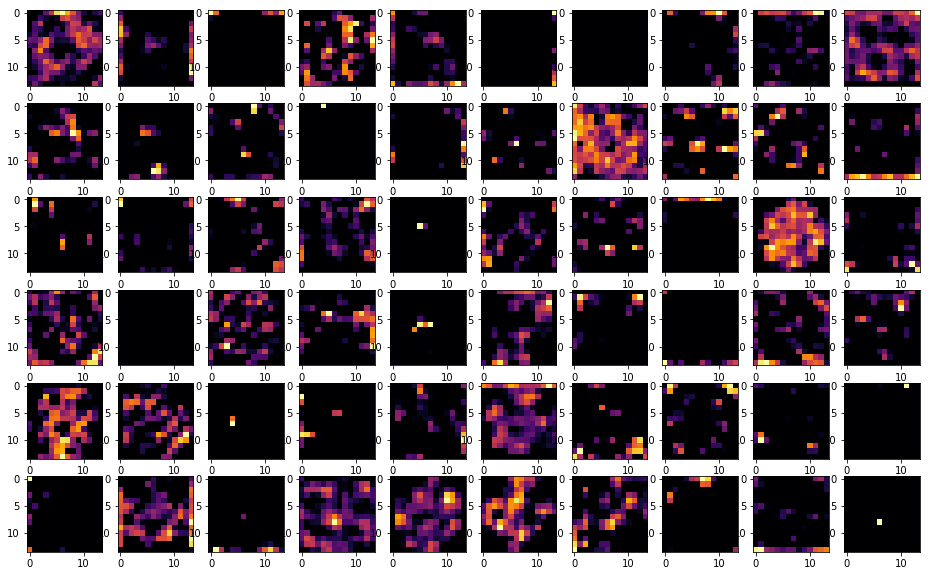

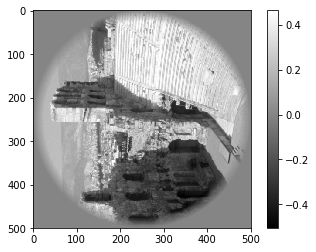

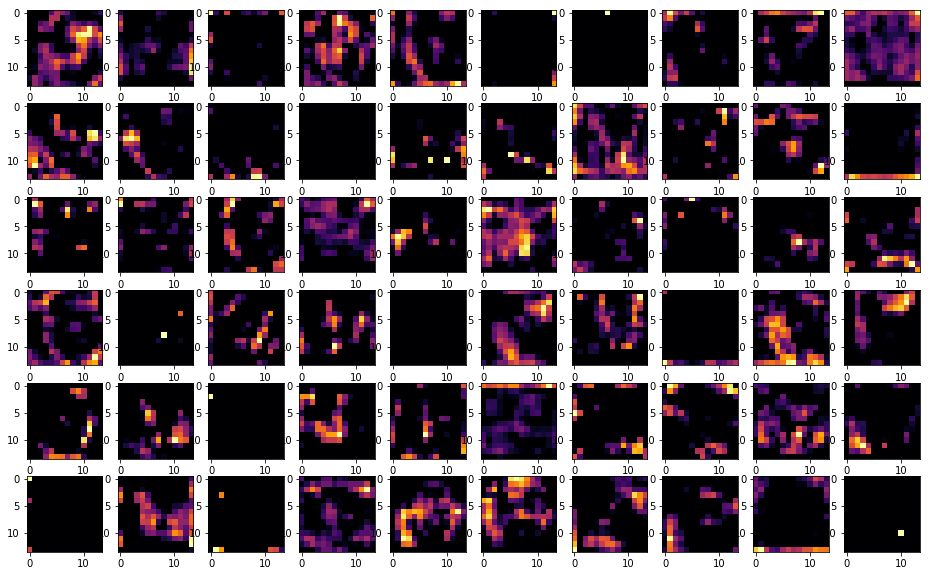

In [25]:
#that worries me - let's look at some of the features
STIM_PATH="/share/kalanit/biac2/kgs/projects/Dawn/CS431/data/full_res/"
with h5py.File(os.path.join(STIM_PATH,"Stimuli_Trn_FullRes_01.mat"),'r') as f:
    stim_set1 = f['stimTrn'][:]
for image_idx in [1, 10]:
    plt.figure()

    plt.imshow(stim_set1[:,:,image_idx], cmap = "gray")
    plt.colorbar()

    fav_image = train_features[image_idx,:,:,:]
    fav_image = np.moveaxis(fav_image, -1, 0) #put num of features in first column

    fig = plt.figure(figsize=(16,10))

    for idx in xrange(60):
        ax = fig.add_subplot(6, 10, idx+1) 
        ax.imshow(fav_image[idx,:,:], cmap="inferno") 
#okay they look fine so that's not the issue

In [30]:
#okay well let's try ridge
resRidge_sub = train_and_test_scikit_regressor(features=train_feats, 
                                labels=S1_V4_train,
                                splits=splits,
                                model_class=RidgeCV,
                                model_args={'alphas':
                                            [1e-4, 1e-3, 1e-2, 1e-1, 1]},
                                return_models=True)
print(resRidge_sub['train']['mean_rsquared']) 
print(resRidge_sub['test']['mean_rsquared']) #better on train but similarly bad on test

0.07752186325634054
0.0019328671513851067


In [32]:
#and on the validation data? (just picking the model from the first split)
S1_pred_val_resRidge = resRidge_sub['models'][0].predict(val_feats)
S1_pred_val_resRidge.shape

(120, 1535)

In [34]:
S1_val_results_ridge = evaluate_regression_results(S1_pred_val_resRidge,S1_V4_test)
S1_val_results_ridge

{'pearson': 0.0023077910887080925,
 'pearson_array': array([-0.0523056 , -0.0498023 , -0.06581365, ...,  0.09794862,
         0.03453299,  0.00299421]),
 'rsquared': 0.004541045693308038,
 'rsquared_array': array([2.73587616e-03, 2.48026864e-03, 4.33143589e-03, ...,
        9.59393213e-03, 1.19252771e-03, 8.96528204e-06]),
 'spearman': 0.0019167997777623442,
 'spearman_array': array([-0.10606987,  0.0019168 , -0.03910688, ...,  0.06971317,
        -0.0036322 , -0.04485034])}

Text(0.5,1,'Distribution of voxel r-squared on validation data')

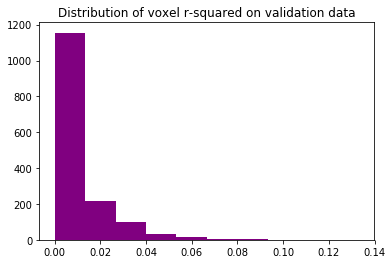

In [40]:
plt.hist(S1_val_results_ridge['rsquared_array'], color='purple') #yeah - not good
plt.title('Distribution of voxel r-squared on validation data')

In [38]:
#let's compare this to 50dim PLS and then plot
resPLS_50 = train_and_test_scikit_regressor(features=train_feats, 
                                labels=S1_V4_train,
                                splits=splits,
                                model_class=PLSRegression,
                                model_args={'n_components': 50,
                                            'scale': False},
                                return_models = True)
print(resPLS_50['train']['mean_rsquared']) 
print(resPLS_50['test']['mean_rsquared']) 

0.04232859899482057
0.0019191099594475236


Text(0.5,1,'Distribution of voxel r-squared on validation data')

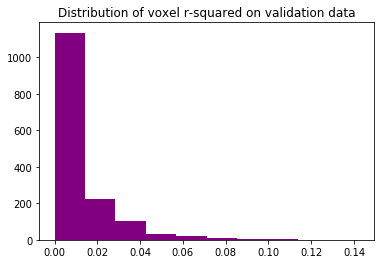

In [41]:
#and on the validation data? (just picking the model from the first split)
S1_pred_val_resPLS50 = resPLS_50['models'][0].predict(val_feats)
S1_val_results_PLS50 = evaluate_regression_results(S1_pred_val_resPLS50,S1_V4_test)
plt.hist(S1_val_results_PLS50['rsquared_array'], color = 'purple')
plt.title('Distribution of voxel r-squared on validation data')

In [53]:
test_mean_ridge = np.mean(resRidge_sub['test']['by_split'][0]['rsquared_array'])
test_std_ridge = np.std(resRidge_sub['test']['by_split'][0]['rsquared_array'])

train_mean_ridge = np.mean(resRidge_sub['train']['by_split'][0]['rsquared_array'])
train_std_ridge = np.std(resRidge_sub['train']['by_split'][0]['rsquared_array'])

val_mean_ridge = np.mean(S1_val_results_ridge['rsquared_array'])
val_std_ridge = np.std(S1_val_results_ridge['rsquared_array'])

In [63]:
test_mean_PLS50 = np.mean(resPLS_50['test']['by_split'][0]['rsquared_array'])
test_std_PLS50 = np.std(resPLS_50['test']['by_split'][0]['rsquared_array'])

train_mean_PLS50 = np.mean(resPLS_50['train']['by_split'][0]['rsquared_array'])
train_std_PLS50 = np.std(resPLS_50['train']['by_split'][0]['rsquared_array'])

val_mean_PLS50 = np.mean(S1_val_results_PLS50['rsquared_array'])
val_std_PLS50 = np.std(S1_val_results_PLS50['rsquared_array'])

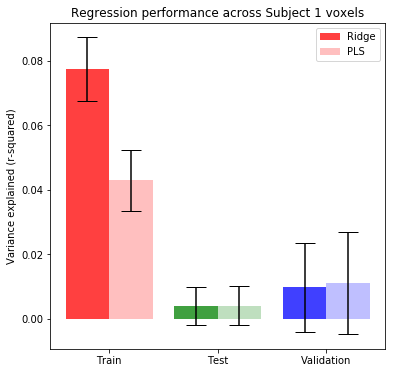

In [92]:
#plot
cats = ['Train', 'Test', 'Validation']
x_pos = np.arange(len(cats))
barWidth = .4
# Set position of bar on X axis
r1 = np.arange(len(cats))
r2 = [x + barWidth for x in r1]

Ridge_rs = [train_mean_ridge, test_mean_ridge,val_mean_ridge]
Ridge_error = [train_std_ridge, test_std_ridge, val_std_ridge]
PLS_rs = [train_mean_PLS50, test_mean_PLS50,val_mean_PLS50]
PLS_error = [train_std_PLS50, test_std_PLS50, val_std_PLS50]

#fig, ax = plt.subplots()
fig = plt.figure(figsize=(6, 6))
plt.bar(r1, Ridge_rs, yerr=Ridge_error, width=barWidth, color=['red', 'green', 'blue'],\
       align='center', alpha=0.75, ecolor='black', capsize=10, label='Ridge')
plt.bar(r2, PLS_rs, yerr=PLS_error,  width=barWidth, color=['red', 'green', 'blue'],\
       align='center', alpha=0.25, ecolor='black', capsize=10, label='PLS')
plt.ylabel('Variance explained (r-squared)')
plt.xticks([r + barWidth/2 for r in range(len(cats))], cats)
plt.title('Regression performance across Subject 1 voxels')

plt.legend()
plt.show

plt.savefig('figs/S1_retinawarp_regs.png')

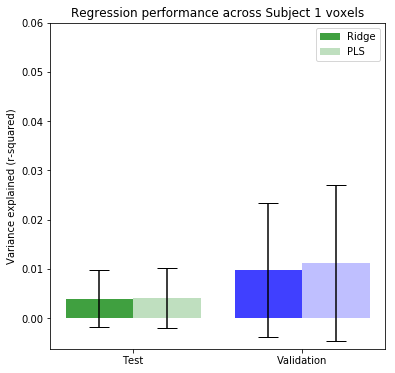

In [114]:
#plot test and val only for comparison
cats = ['Test', 'Validation']
x_pos = np.arange(len(cats))
barWidth = .4
# Set position of bar on X axis
r1 = np.arange(len(cats))
r2 = [x + barWidth for x in r1]

Ridge_rs = [test_mean_ridge,val_mean_ridge]
Ridge_error = [test_std_ridge, val_std_ridge]
PLS_rs = [test_mean_PLS50,val_mean_PLS50]
PLS_error = [test_std_PLS50, val_std_PLS50]

#fig, ax = plt.subplots()
fig = plt.figure(figsize=(6, 6))
plt.bar(r1, Ridge_rs, yerr=Ridge_error, width=barWidth, color=[ 'green', 'blue'],\
       align='center', alpha=0.75, ecolor='black', capsize=10, label='Ridge')
plt.bar(r2, PLS_rs, yerr=PLS_error,  width=barWidth, color=['green', 'blue'],\
       align='center', alpha=0.25, ecolor='black', capsize=10, label='PLS')
plt.ylabel('Variance explained (r-squared)')
plt.xticks([r + barWidth/2 for r in range(len(cats))], cats)
plt.title('Regression performance across Subject 1 voxels')
plt.ylim(top=.06)

plt.legend()
plt.show

plt.savefig('figs/S1_retinawarp_regs_notrain.png')

Text(0.5,1,'Distribution of best voxel r-squared on validation data')

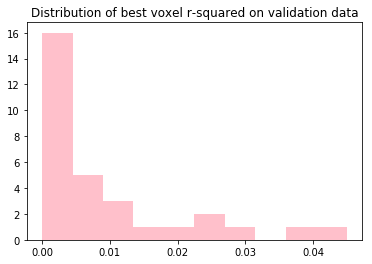

In [112]:
#we could try just the best voxels from the fit_V4 notebook?
best_vox_inds = np.array([  34,  104,  110,  121,  132,  153,  156,  273,  277,  278,  289,
         293,  303,  304,  319,  338,  349,  350,  351,  423,  503,  504,
         992, 1183, 1227, 1252, 1296, 1297, 1383, 1388, 1458])

vox_to_check = best_vox_inds.shape[0]

best_rs = np.zeros(vox_to_check)
best_pred_val = np.zeros([120,vox_to_check])
best_train_val = np.zeros([1750,vox_to_check])

for idx in range(vox_to_check): 
    
    vox = best_vox_inds[idx]
    
    clf = RidgeCV(alphas=[1e-4, 1e-3, 1e-2, 1e-1, 1])
    clf.fit(train_feats_sub, S1_V4_train[:,vox]) 
    
    best_train_val[:,idx] = clf.predict(train_feats_sub)
    best_pred_val[:,idx] = clf.predict(val_feats_sub)
    results = evaluate_regression_results(best_pred_val[:,idx],S1_V4_test[:,vox])
    
    best_rs[idx] = results['rsquared']

plt.hist(best_rs, color = 'pink')
plt.title('Distribution of best voxel r-squared on validation data')

## Regressions - Subject 2

In [94]:
#For subject 2 let's 25 dims since 50 takes forever and didn't give us a big improvement
#(also using sub features cux reached max iters with the whole set)
S2_resPLS_25 = train_and_test_scikit_regressor(features=train_feats_sub, 
                                labels=S2_V4_train,
                                splits=splits,
                                model_class=PLSRegression,
                                model_args={'n_components': 25,
                                            'scale': False},
                                return_models=True)
print(S2_resPLS_25['train']['mean_rsquared']) 
print(S2_resPLS_25['test']['mean_rsquared']) 

0.025643683627991097
0.0019058924470008829


Text(0.5,1,'Distribution of voxel r-squared on validation data')

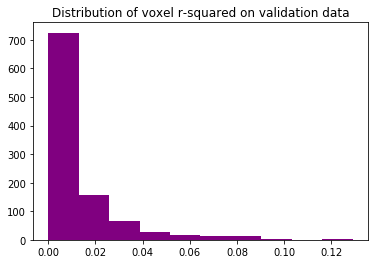

In [96]:
#now on the validation data? (just picking the model from the first split)
S2_pred_val_resPLS25 = S2_resPLS_25['models'][0].predict(val_feats_sub)
S2_val_results_PLS25 = evaluate_regression_results(S2_pred_val_resPLS25,S2_V4_test)
plt.hist(S2_val_results_PLS25['rsquared_array'], color = 'purple')
plt.title('Distribution of voxel r-squared on validation data')

In [97]:
#now ridge regression
S2_resRidge = train_and_test_scikit_regressor(features=train_feats, 
                                labels=S2_V4_train,
                                splits=splits,
                                model_class=RidgeCV,
                                model_args={'alphas':
                                            [1e-4, 1e-3, 1e-2, 1e-1, 1]},
                                return_models=True)
print(S2_resRidge['train']['mean_rsquared']) 
print(S2_resRidge['test']['mean_rsquared']) 

0.0774239150789585
0.001923909017896974


Text(0.5,1,'Distribution of voxel r-squared on validation data')

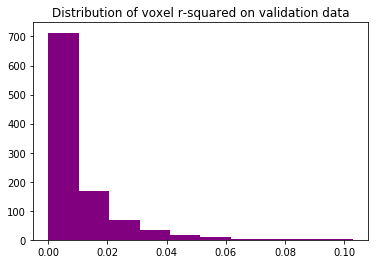

In [98]:
#ridge validation
S2_pred_val_resRidge = S2_resRidge['models'][0].predict(val_feats)
S2_val_results_Ridge = evaluate_regression_results(S2_pred_val_resRidge,S2_V4_test)
plt.hist(S2_val_results_Ridge['rsquared_array'], color = 'purple')
plt.title('Distribution of voxel r-squared on validation data')

In [100]:
#summary stats
S2_test_mean_ridge = np.mean(S2_resRidge['test']['by_split'][0]['rsquared_array'])
S2_test_std_ridge = np.std(S2_resRidge['test']['by_split'][0]['rsquared_array'])

S2_train_mean_ridge = np.mean(S2_resRidge['train']['by_split'][0]['rsquared_array'])
S2_train_std_ridge = np.std(S2_resRidge['train']['by_split'][0]['rsquared_array'])

S2_val_mean_ridge = np.mean(S2_val_results_Ridge['rsquared_array'])
S2_val_std_ridge = np.std(S2_val_results_Ridge['rsquared_array'])

S2_test_mean_PLS25 = np.mean(S2_resPLS_25['test']['by_split'][0]['rsquared_array'])
S2_test_std_PLS25 = np.std(S2_resPLS_25['test']['by_split'][0]['rsquared_array'])

S2_train_mean_PLS25 = np.mean(S2_resPLS_25['train']['by_split'][0]['rsquared_array'])
S2_train_std_PLS25 = np.std(S2_resPLS_25['train']['by_split'][0]['rsquared_array'])

S2_val_mean_PLS25 = np.mean(S2_val_results_PLS25['rsquared_array'])
S2_val_std_PLS25 = np.std(S2_val_results_PLS25['rsquared_array'])

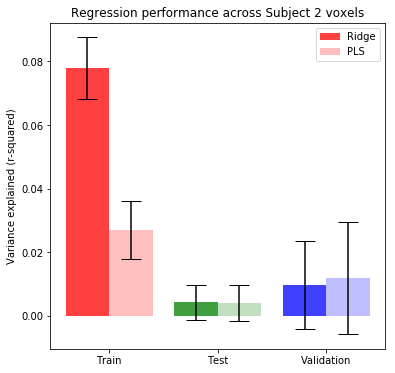

In [103]:
#plot
cats = ['Train', 'Test', 'Validation']
x_pos = np.arange(len(cats))
barWidth = .4
# Set position of bar on X axis
r1 = np.arange(len(cats))
r2 = [x + barWidth for x in r1]

S2_Ridge_rs = [S2_train_mean_ridge, S2_test_mean_ridge,S2_val_mean_ridge]
S2_Ridge_error = [S2_train_std_ridge, S2_test_std_ridge, S2_val_std_ridge]
S2_PLS_rs = [S2_train_mean_PLS25, S2_test_mean_PLS25,S2_val_mean_PLS25]
S2_PLS_error = [S2_train_std_PLS25, S2_test_std_PLS25, S2_val_std_PLS25]

#fig, ax = plt.subplots()
fig = plt.figure(figsize=(6, 6))
plt.bar(r1, S2_Ridge_rs, yerr=S2_Ridge_error, width=barWidth, color=['red', 'green', 'blue'],\
       align='center', alpha=0.75, ecolor='black', capsize=10, label='Ridge')
plt.bar(r2, S2_PLS_rs, yerr=S2_PLS_error,  width=barWidth, color=['red', 'green', 'blue'],\
       align='center', alpha=0.25, ecolor='black', capsize=10, label='PLS')
plt.ylabel('Variance explained (r-squared)')
plt.xticks([r + barWidth/2 for r in range(len(cats))], cats)
plt.title('Regression performance across Subject 2 voxels')

plt.legend()
plt.show

plt.savefig('figs/S2_retinawarp_regs.png')

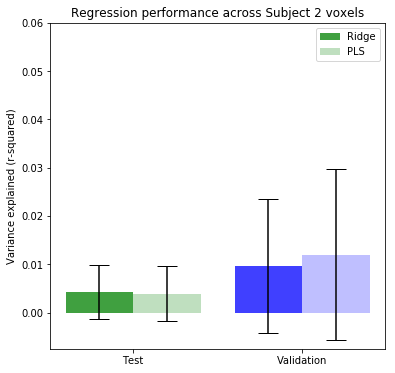

In [118]:
#plot test and val only for comparison
cats = ['Test', 'Validation']
x_pos = np.arange(len(cats))
barWidth = .4
# Set position of bar on X axis
r1 = np.arange(len(cats))
r2 = [x + barWidth for x in r1]

S2_Ridge_rs = [S2_test_mean_ridge,S2_val_mean_ridge]
S2_Ridge_error = [S2_test_std_ridge, S2_val_std_ridge]
S2_PLS_rs = [S2_test_mean_PLS25, S2_val_mean_PLS25]
S2_PLS_error = [S2_test_std_PLS25, S2_val_std_PLS25]

#fig, ax = plt.subplots()
fig = plt.figure(figsize=(6, 6))
plt.bar(r1, S2_Ridge_rs, yerr=S2_Ridge_error, width=barWidth, color=[ 'green', 'blue'],\
       align='center', alpha=0.75, ecolor='black', capsize=10, label='Ridge')
plt.bar(r2, S2_PLS_rs, yerr=S2_PLS_error,  width=barWidth, color=['green', 'blue'],\
       align='center', alpha=0.25, ecolor='black', capsize=10, label='PLS')
plt.ylabel('Variance explained (r-squared)')
plt.xticks([r + barWidth/2 for r in range(len(cats))], cats)
plt.title('Regression performance across Subject 2 voxels')
plt.ylim(top=.06)

plt.legend()
plt.show

plt.savefig('figs/S2_retinawarp_regs_notrain.png')

## Average V4

In [119]:
mean_S1_V4_train = np.mean(S1_V4_train,axis=1)
std_S1_V4_train = np.std(S1_V4_train,axis=1)

mean_S1_V4_test = np.mean(S1_V4_test,axis=1)
std_S1_V4_test = np.std(S1_V4_test,axis=1)

In [126]:
#back to PLS
clf = PLSRegression(n_components=1) 
clf.fit(train_feats, mean_S1_V4_train) 

train_val = clf.predict(train_feats)
pred_val = clf.predict(val_feats)
train_results = evaluate_regression_results(train_val[:,0],mean_S1_V4_train)
results = evaluate_regression_results(pred_val[:,0],mean_S1_V4_test)
print(train_results['rsquared'])
print(results['rsquared'])

0.042517402143747
0.013025740657541397


In [ ]:
#okay the average is not as good as the non retinawarped version...